In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

import pandas as pd
import os
import numpy as np
import time
import datetime

##matrix math
import math


os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())

Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
# %load SM
#!/usr/bin/env python

# In[ ]:


#load the data
def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'])
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)

    # Set index
    dataset_total.set_index('Date', inplace=True)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
    
    #New
    line= int(split_line)+window_length
    
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore,line

def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='mean_squared_error'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 32, activation='relu'))
    
    
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 32, activation='relu'))
    
    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1,activation='linear'))
   
    
              
    model.compile(optimizer =optimizer, loss = loss)

    
    return model

#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model

# test the model
def test_model(model, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore

#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in Bitcoin Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    return  return_change_predict, return_change_real, fig_2

def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0

def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

# Classification function

def classify_range(variable_name):
    
    classification[variable_name+'_range']=0

    for i in range(classification.shape[0]):
        if classification[variable_name][i]<=0.002 and classification[variable_name][i]>=-0.002:
            classification[variable_name+'_range'][i]=0
        
        elif classification[variable_name][i]<=-0.002 and classification[variable_name][i]>=-0.004:
            classification[variable_name+'_range'][i]=-1
        
        elif classification[variable_name][i]<=-0.004 and classification[variable_name][i]>=-0.006:
            classification[variable_name+'_range'][i]=-2
        
        elif classification[variable_name][i]<=-0.006 and classification[variable_name][i]>=-0.008:
            classification[variable_name+'_range'][i]=-3
        
        elif classification[variable_name][i]<=-0.008 and classification[variable_name][i]>=-0.010:
            classification[variable_name+'_range'][i]=-4
        
        elif classification[variable_name][i]<=-0.010 and classification[variable_name][i]>=-0.012:
            classification[variable_name+'_range'][i]=-5
        
        elif classification[variable_name][i]<=-0.012 and classification[variable_name][i]>=-0.014:
            classification[variable_name+'_range'][i]=-6
        
        elif classification[variable_name][i]<=-0.014 and classification[variable_name][i]>=-0.016:
            classification[variable_name+'_range'][i]=-7
        
        elif classification[variable_name][i]<=-0.016 and classification[variable_name][i]>=-0.018:
            classification[variable_name+'_range'][i]=-8
        
        elif classification[variable_name][i]<=-0.018 and classification[variable_name][i]>=-0.020:
            classification[variable_name+'_range'][i]=-9
        
        elif classification[variable_name][i]<=-0.020:
            classification[variable_name+'_range'][i]=-10
        
        #positive value
        elif classification[variable_name][i]<=0.004 and classification[variable_name][i]>=0.002:
            classification[variable_name+'_range'][i]=1
        
        elif classification[variable_name][i]<=0.006 and classification[variable_name][i]>=0.004:
            classification[variable_name+'_range'][i]=2
        
        elif classification[variable_name][i]<=0.008 and classification[variable_name][i]>=0.006:
            classification[variable_name+'_range'][i]=3
        
        elif classification[variable_name][i]<=0.010 and classification[variable_name][i]>=0.008:
            classification[variable_name+'_range'][i]=4
        
        elif classification[variable_name][i]<=0.012 and classification[variable_name][i]>=0.010:
            classification[variable_name+'_range'][i]=5
        
        elif classification[variable_name][i]<=0.014 and classification[variable_name][i]>=0.012:
            classification[variable_name+'_range'][i]=6
        
        elif classification[variable_name][i]<=0.016 and classification[variable_name][i]>=0.014:
            classification[variable_name+'_range'][i]=7
        
        elif classification[variable_name][i]<=0.018 and classification[variable_name][i]>=0.016:
            classification[variable_name+'_range'][i]=8
        
        elif classification[variable_name][i]<=0.020 and classification[variable_name][i]>=0.018:
            classification[variable_name+'_range'][i]=9
         
        else:
            classification[variable_name+'_range'][i]=10
    return classification

def find_the_successful_rate(classification):
    successful_number=0
    for i in range(classification.shape[0]):
        if classification['real_y_test_range'][i]==classification['real_y_predict_range'][i]:
            successful_number+=1
    successful_rate=round(successful_number/classification.shape[0],4)
    return successful_rate


(396, 30, 98)
(396,)
(180, 30, 98)
(180,)
30
(180,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            16768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 32)            0         
___________________________________

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 277 samples, validate on 119 samples
Epoch 1/100
277/277 [==============================] - 3s 10ms/step - loss: 0.0767 - val_loss: 0.0154
Epoch 2/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0114
Epoch 3/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0078
Epoch 4/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0063
Epoch 5/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0060
Epoch 6/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0061
Epoch 7/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0065
Epoch 8/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0062
Epoch 9/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0073
Epoch 10/100
277/277 [======================

Epoch 81/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0197 - val_loss: 0.0109
Epoch 82/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 0.0116
Epoch 83/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0192 - val_loss: 0.0107
Epoch 84/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0205 - val_loss: 0.0091
Epoch 85/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.0100
Epoch 86/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0193 - val_loss: 0.0105
Epoch 87/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.0090
Epoch 88/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0185 - val_loss: 0.0106
Epoch 89/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0186 - val_loss: 0.0127
Epoch 90/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0201

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.047059        0.085464                -10   
2018-11-26    -0.058642        0.083732                -10   
2018-11-27     0.081967        0.080861                 10   
2018-11-28    -0.078788        0.078236                -10   
2018-11-29    -0.049342        0.073570                -10   
2018-11-30     0.027682        0.067357                 10   
2018-12-01    -0.033670        0.061634                -10   
2018-12-02    -0.097561        0.056609                -10   
2018-12-03    -0.046332        0.052049                -10   
2018-12-04    -0.113360        0.049959                -10   
2018-12-05    -0.155251        0.050430                -10   
2018-12-06    -0.048649        0.053186                -10   
2018-12-07     0.056818        0.058012                 10   
2018-12-08     0.102151        0.063939                 10   
2018-12-

C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


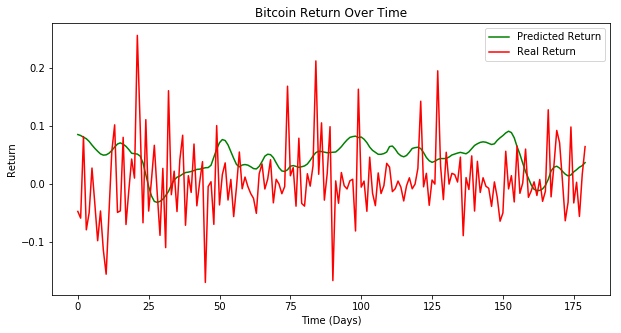

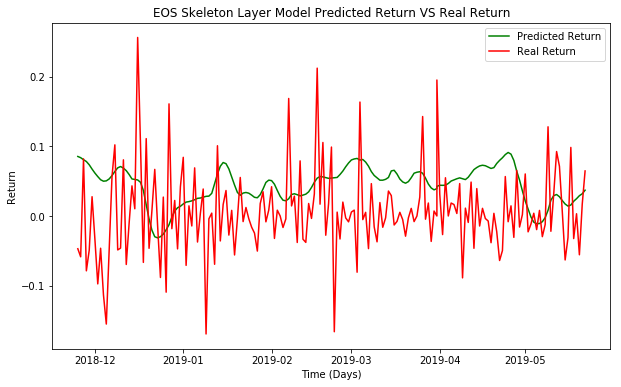

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

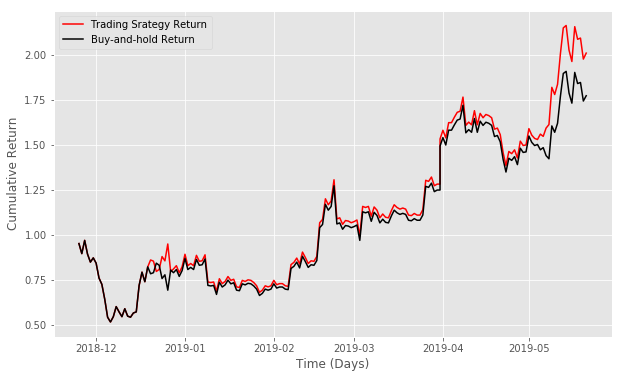

Annulized Sharpe Ratio is 0.9672184301634705
Annulized Sharpe Ratio for buy and hold strategy is 0.7832429664222199


In [3]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_EOS-USD.csv", 30, 0.6880)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("EOS Skeleton Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_skeleton_EOS.csv')

(1088, 30, 110)
(1088,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 30, 32)            18304     
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_18 (LSTM)      

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 761 samples, validate on 327 samples
Epoch 1/100
761/761 [==============================] - 4s 6ms/step - loss: 0.0302 - val_loss: 0.0059
Epoch 2/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0056
Epoch 3/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0056
Epoch 4/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0123 - val_loss: 0.0058
Epoch 5/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0059
Epoch 6/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 7/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 8/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0063
Epoch 9/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0062
Epoch 10/100
761/761 [=======================

Epoch 81/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0059
Epoch 82/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0057
Epoch 83/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0057
Epoch 84/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0064
Epoch 85/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0064
Epoch 86/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0066
Epoch 87/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 88/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0078
Epoch 89/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 90/100
761/761 [==============================] - 1s 1ms/step - loss: 0.0097

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.067495        0.010166                -10   
2018-11-26     0.012125        0.011239                  6   
2018-11-27     0.115165        0.012427                 10   
2018-11-28    -0.043945        0.012419                -10   
2018-11-29    -0.039241        0.012424                -10   
2018-11-30     0.049880        0.012220                 10   
2018-12-01    -0.021435        0.011848                -10   
2018-12-02    -0.066661        0.012033                -10   
2018-12-03     0.014691        0.012064                  7   
2018-12-04    -0.075123        0.012910                -10   
2018-12-05    -0.109678        0.013515                -10   
2018-12-06     0.035165        0.014724                 10   
2018-12-07    -0.023181        0.015753                -10   
2018-12-08     0.032590        0.016133                 10   
2018-12-

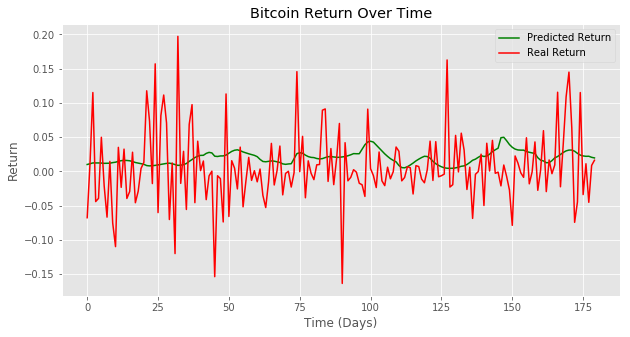

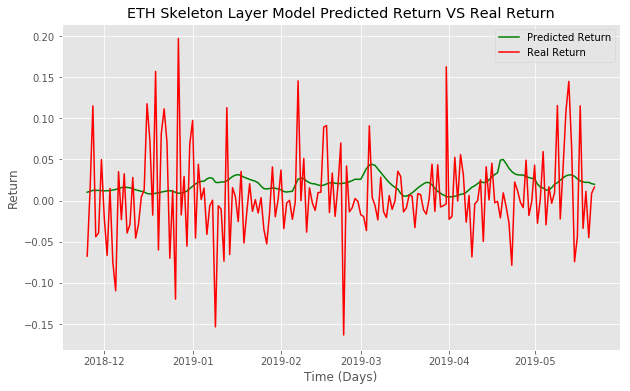

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

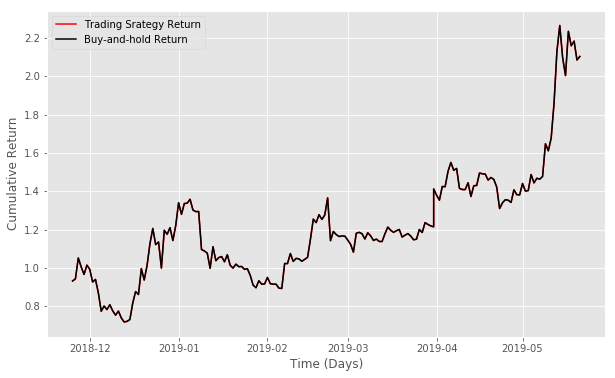

Annulized Sharpe Ratio is 1.056727261539883
Annulized Sharpe Ratio for buy and hold strategy is 1.056727261539883


In [8]:
#Compile together
#ETH 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_ETH-USD.csv", 30, 0.8582)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ETH Skeleton Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_skeleton_ETH.csv')

(1740, 30, 108)
(1740,)
(180, 30, 108)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_6 (LSTM)       

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1218 samples, validate on 522 samples
Epoch 1/100
1218/1218 [==============================] - 4s 4ms/step - loss: 0.0160 - val_loss: 0.0018
Epoch 2/100
1218/1218 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 3/100
1218/1218 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/100
1218/1218 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/100
1218/1218 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 6/100
1218/1218 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/100
1218/1218 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/100
1218/1218 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 9/100
1218/1218 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 10/100
1218/1218 [==

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.043450        0.109304                -10   
2018-11-26     0.055254        0.109287                 10   
2018-11-27     0.112432        0.109243                 10   
2018-11-28    -0.027433        0.108971                -10   
2018-11-29    -0.054335        0.108070                -10   
2018-11-30     0.071272        0.106915                 10   
2018-12-01    -0.015826        0.105906                 -7   
2018-12-02    -0.085765        0.104547                -10   
2018-12-03     0.008143        0.103068                  4   
2018-12-04    -0.065590        0.101150                -10   
2018-12-05    -0.082642        0.098673                -10   
2018-12-06    -0.057671        0.095620                -10   
2018-12-07    -0.020000        0.092760                 -9   
2018-12-08     0.044898        0.091427                 10   
2018-12-

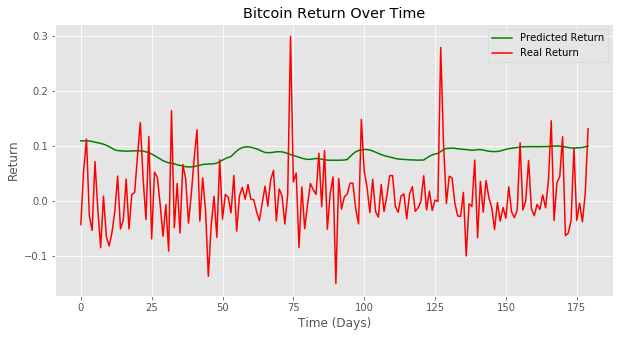

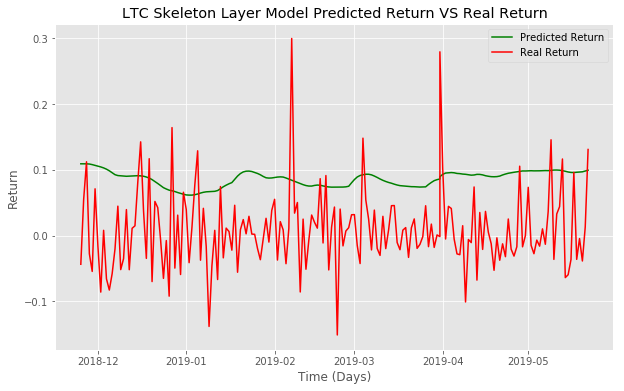

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

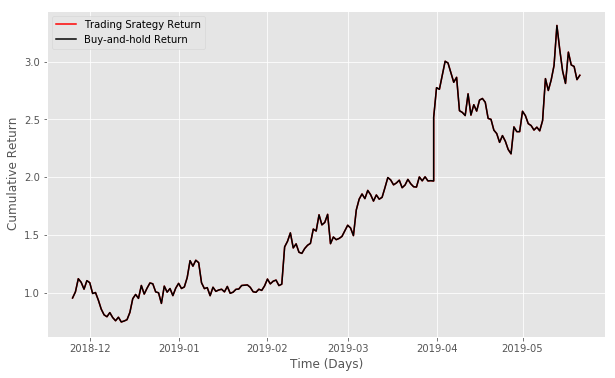

Annulized Sharpe Ratio is 1.4936024962189969
Annulized Sharpe Ratio for buy and hold strategy is 1.4936024962189969


In [4]:
#Compile together
#LTC
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_LTC-USD.csv", 30, 0.9063)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("LTC Skeleton Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_skeleton_LTC.csv')

(1286, 30, 110)
(1286,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_9 (LSTM)       

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 771 samples, validate on 515 samples
Epoch 1/100
771/771 [==============================] - 4s 5ms/step - loss: 0.0190 - val_loss: 0.0036
Epoch 2/100
771/771 [==============================] - 1s 810us/step - loss: 0.0067 - val_loss: 0.0029
Epoch 3/100
771/771 [==============================] - 1s 769us/step - loss: 0.0052 - val_loss: 0.0015
Epoch 4/100
771/771 [==============================] - 1s 814us/step - loss: 0.0052 - val_loss: 0.0018
Epoch 5/100
771/771 [==============================] - 1s 799us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 6/100
771/771 [==============================] - 1s 803us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 7/100
771/771 [==============================] - 1s 806us/step - loss: 0.0049 - val_loss: 0.0014
Epoch 8/100
771/771 [==============================] - 1s 825us/step - loss: 0.0047 - val_loss: 0.0014
Epoch 9/100
771/771 [==============================] - 1s 784us/step - loss: 0.0047 - val_loss: 0.0020
Epoch 10/100
771/771 [=======

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.050767       -0.006966                -10   
2018-11-26     0.010028       -0.007691                  5   
2018-11-27     0.082460       -0.008468                 10   
2018-11-28    -0.028790       -0.008663                -10   
2018-11-29    -0.047744       -0.009221                -10   
2018-11-30     0.029477       -0.009729                 10   
2018-12-01    -0.011239       -0.009974                 -5   
2018-12-02    -0.061434       -0.009870                -10   
2018-12-03     0.014706       -0.009027                  7   
2018-12-04    -0.042342       -0.008023                -10   
2018-12-05    -0.087834       -0.006430                -10   
2018-12-06    -0.016591       -0.004564                 -8   
2018-12-07     0.016871       -0.002827                  8   
2018-12-08     0.020169       -0.001374                 10   
2018-12-

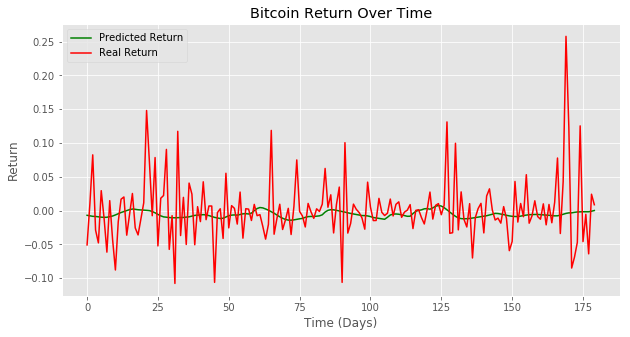

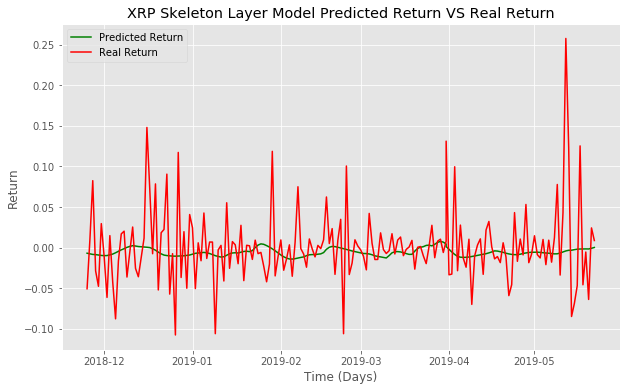

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

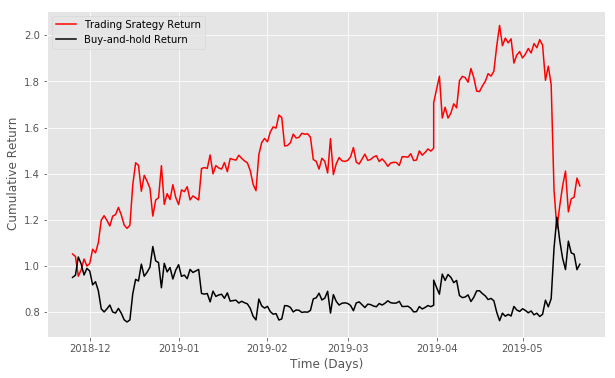

Annulized Sharpe Ratio is 0.2630776687991308
Annulized Sharpe Ratio for buy and hold strategy is -0.32246454698985777


In [5]:
#Compile together
#XRP
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_XRP-USD.csv", 30, 0.8773)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 64, 100, .4)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("XRP Skeleton Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_skeleton_XRP.csv')

(640, 30, 112)
(640,)
(180, 30, 112)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30, 32)            18560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_12 (LSTM)        

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 448 samples, validate on 192 samples
Epoch 1/100
448/448 [==============================] - 4s 8ms/step - loss: 0.0225 - val_loss: 0.0066
Epoch 2/100
448/448 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0033
Epoch 3/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0042
Epoch 4/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 5/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0033
Epoch 6/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 7/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0046
Epoch 8/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0034
Epoch 9/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 10/100
448/448 [=======================

Epoch 81/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0035
Epoch 82/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 83/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 84/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0035
Epoch 85/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 86/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 87/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 88/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 89/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 90/100
448/448 [==============================] - 1s 1ms/step - loss: 0.0071

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.058028        0.033558                -10   
2018-11-26     0.094647        0.033255                 10   
2018-11-27     0.094796        0.036799                 10   
2018-11-28     0.101435        0.040604                 10   
2018-11-29    -0.081898        0.042313                -10   
2018-11-30    -0.003578        0.041173                 -1   
2018-12-01    -0.011763        0.038751                 -5   
2018-12-02    -0.111014        0.030115                -10   
2018-12-03     0.052290        0.019895                 10   
2018-12-04    -0.115457        0.015412                -10   
2018-12-05    -0.119473        0.014907                -10   
2018-12-06     0.029063        0.017994                 10   
2018-12-07    -0.037935        0.024108                -10   
2018-12-08     0.056453        0.026521                 10   
2018-12-

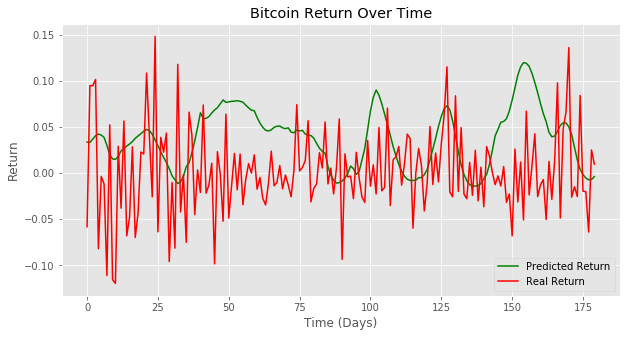

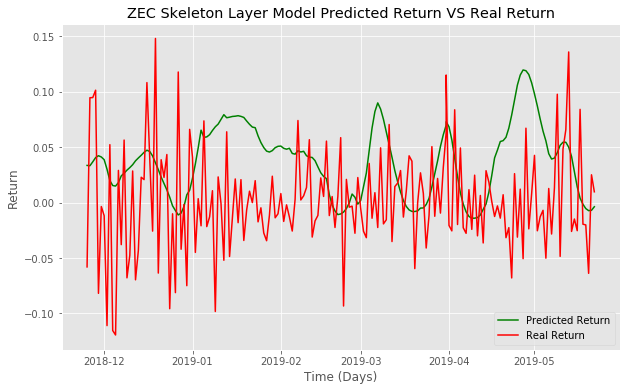

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

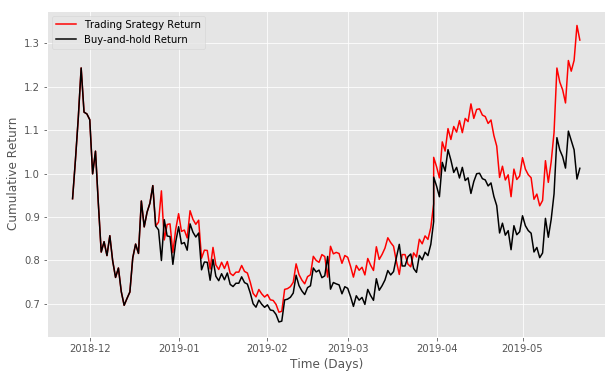

Annulized Sharpe Ratio is 0.19584551163407285
Annulized Sharpe Ratio for buy and hold strategy is -0.2905846972302419


In [6]:
#Compile together
#ZEC
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_ZEC-USD.csv", 30, 0.7808)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ZEC Skeleton Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_skeleton_ZEC.csv')

(2934, 30, 105)
(2934,)
(180, 30, 105)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 32)            17664     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_15 (LSTM)      

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2347 samples, validate on 587 samples
Epoch 1/100
2347/2347 [==============================] - 11s 5ms/step - loss: 0.0016 - val_loss: 5.6179e-04
Epoch 2/100
2347/2347 [==============================] - 4s 2ms/step - loss: 9.4521e-04 - val_loss: 2.9275e-04
Epoch 3/100
2347/2347 [==============================] - 4s 2ms/step - loss: 8.6824e-04 - val_loss: 4.7101e-04
Epoch 4/100
2347/2347 [==============================] - 4s 2ms/step - loss: 7.9669e-04 - val_loss: 2.2628e-04
Epoch 5/100
2347/2347 [==============================] - 4s 2ms/step - loss: 7.5905e-04 - val_loss: 1.7624e-04
Epoch 6/100
2347/2347 [==============================] - 4s 2ms/step - loss: 6.9133e-04 - val_loss: 1.5757e-04
Epoch 7/100
2347/2347 [==============================] - 4s 2ms/step - loss: 6.7414e-04 - val_loss: 2.0574e-04
Epoch 8/100
2347/2347 [==============================] - 4s 2ms/step - loss: 6.6644e-04 - val_loss: 1.9683e-04
Epoch 9/100
2347/2347 [==============================] - 4s 2ms/step

Epoch 74/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.9141e-04 - val_loss: 2.4687e-04
Epoch 75/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.6433e-04 - val_loss: 1.5529e-04
Epoch 76/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.9881e-04 - val_loss: 2.1819e-04
Epoch 77/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.5223e-04 - val_loss: 3.8626e-04
Epoch 78/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.5776e-04 - val_loss: 1.5022e-04
Epoch 79/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.9299e-04 - val_loss: 1.4981e-04
Epoch 80/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.9314e-04 - val_loss: 1.4919e-04
Epoch 81/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.9148e-04 - val_loss: 1.4913e-04
Epoch 82/100
2347/2347 [==============================] - 3s 1ms/step - loss: 5.6969e-04 - val_loss: 1.9

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-24     0.038930        0.002903                 10   
2018-11-25    -0.054833        0.002903                -10   
2018-11-26     0.010146        0.002903                  5   
2018-11-27     0.115240        0.002903                 10   
2018-11-28     0.005427        0.002903                  2   
2018-11-29    -0.064623        0.002903                -10   
2018-11-30     0.046834        0.002903                 10   
2018-12-01    -0.012770        0.002903                 -6   
2018-12-02    -0.065748        0.002903                -10   
2018-12-03     0.019897        0.002903                  9   
2018-12-04    -0.053416        0.002903                -10   
2018-12-05    -0.067518        0.002903                -10   
2018-12-06    -0.018538        0.002903                 -9   
2018-12-07     0.011840        0.002903                  5   
2018-12-

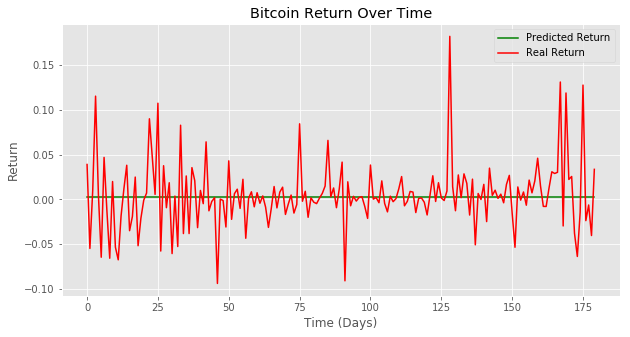

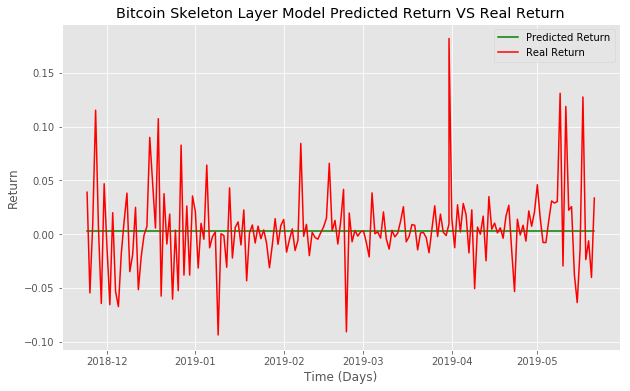

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

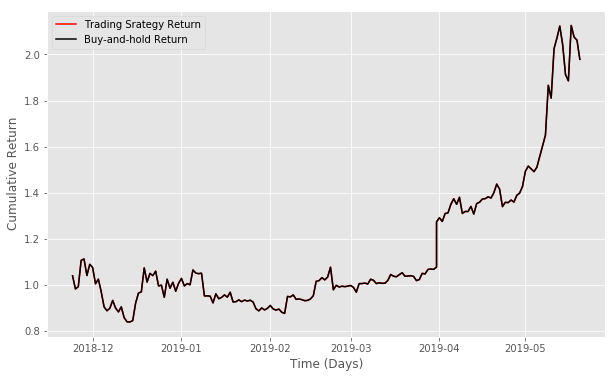

Annulized Sharpe Ratio is 1.0620883732767286
Annulized Sharpe Ratio for buy and hold strategy is 1.0620883732767286


In [7]:
#Compile together
#Bitcoin
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("Bitcoin.csv", 30, 0.9422)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.3)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("Bitcoin Skeleton Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_skeleton_Bit.csv')